In [1]:
import init
import constants as cn
import numpy as np
import pandas as pd
import parse_datetime as pdt
import altair as alt
# import matplotlib.pyplot as plt
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [186]:
sim_data = pd.read_csv(cn.SIMULATED_CAR_DATA_FP)

In [ ]:
#Pulling out time from the google dist out
# df['time'] = df.apply(lambda x: pdt.ParseDatetime(x['departure_time']).time.hour, axis = 1)

In [181]:
#calculalating variance per blockgroup per departure time using simulated data
df_var = sim_data.groupby(['block_group','departure_time', 'time'])['simulated_traffic_time'].var()
df_var = df_var.to_frame('var').reset_index()

In [182]:
#there are 14 variances for each block group (one for each hour)
#calculate mean variance for each block group
df_var = df_var.groupby(['block_group'])['var'].mean()
df_var = df_var.to_frame('mean').reset_index()

In [183]:
a = alt.Chart(df_var).mark_bar().encode(
    alt.X('mean:Q', bin=alt.BinParams(maxbins=50)),
    y='count()'
)

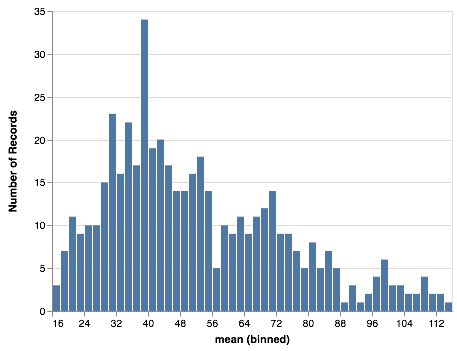

In [184]:
a

In [185]:
#scale the mean variance using gamma distribution a la Woosub

from scipy.stats import gamma

gam_mean = df_var['mean'].mean()
gam_var = df_var['mean'].var()

shape_param = gam_mean ** 2 / gam_var
scale_param = gam_var / gam_mean

YOUR_VALUE = df_var['mean']
df_var['reliability_score'] = 1 - gamma.cdf(YOUR_VALUE, a=shape_param, scale=scale_param)

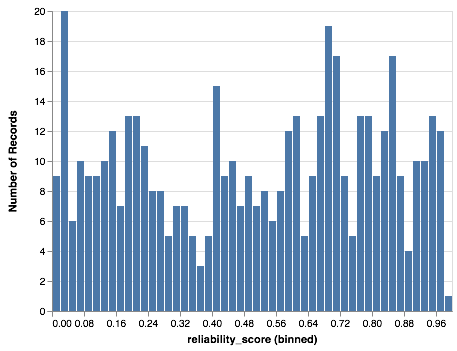

In [63]:
#final reliability index score!
alt.Chart(df_var).mark_bar().encode(
    alt.X('reliability_score:Q', bin=alt.BinParams(maxbins=50)),
    y='count()'
)

In [69]:
###
#Calculating buffer index
sim_data.head()

,Unnamed: 0,block_group,lat,lon,departure_time,distance,duration,duration_in_traffic,class,destination,time,simulated_traffic_time
0,120076,530330001001,47.54841,-122.352194,2018-07-25 07:00:00-07:00,15.624612,28.933333,31.983333,citywide,-74.803784,7,30.686239
1,25460,530330001001,47.54841,-122.352194,2018-07-25 08:00:00-07:00,15.565569,28.400000,39.250000,citywide,-74.803784,8,32.675034
2,89121,530330001001,47.54841,-122.352194,2018-07-25 09:00:00-07:00,15.624612,28.933333,35.900000,citywide,-74.803784,9,31.199236
3,156230,530330001001,47.54841,-122.352194,2018-07-25 10:00:00-07:00,15.624612,28.933333,29.833333,citywide,-74.803784,10,31.786378
4,77191,530330001001,47.54841,-122.352194,2018-07-25 11:00:00-07:00,15.624612,28.933333,30.650000,citywide,-74.803784,11,34.205688


In [81]:
#check quantile calculation separately to make sure groupby + qunatile is working correctly
#not sure about the length of xx - TODO
xx = sim_data[(sim_data['block_group']== 530330001001) & (sim_data['time']==7)]
xx['simulated_traffic_time'].quantile(0.95)

In [90]:
df_buf = sim_data

In [100]:
#calculate 95h quantile for every blockgroup at every hour
quant = df_buf.groupby(['block_group', 'time'])['simulated_traffic_time'].quantile(0.95)
quant_df = quant.to_frame('95th').reset_index()

In [102]:
#calculate mean for every blockgroup at every hour
mean = df_buf.groupby(['block_group', 'time'])['simulated_traffic_time'].mean()
mean_df = mean.to_frame('mean').reset_index()

In [107]:
#merge together to create dataframe
df_buf_index = mean_df.merge(quant_df, on=['block_group', 'time'])

In [108]:
df_buf_index.head()

,block_group,time,mean,95th
0,530330001001,7,16.213524,30.122400
1,530330001001,8,16.379870,30.243563
2,530330001001,9,16.539255,30.410030
3,530330001001,10,16.567028,30.456953
4,530330001001,11,16.573884,30.504061


In [109]:
#buffer idnex (%) calculation
df_buf_index['index'] = df_buf_index['95th'] - df_buf_index['mean']/ df_buf_index['mean']

In [113]:
#calculate mean percentage buffer index for each blockgroup
buf_index = df_buf_index.groupby(['block_group'])['index'].mean()
buf_index = buf_index.to_frame('index').reset_index()

#make histogram of mean percetage buffer index
buf_index_chart = alt.Chart(buf_index).mark_bar().encode(
    alt.X('index:Q', bin=alt.BinParams(maxbins=50)),
    y='count()'
)

In [167]:
#Calculate percentage of trips under 85th percentile
sim_data.head()

,Unnamed: 0,block_group,lat,lon,departure_time,distance,duration,duration_in_traffic,class,destination,time,simulated_traffic_time
0,120076,530330001001,47.54841,-122.352194,2018-07-25 07:00:00-07:00,15.624612,28.933333,31.983333,citywide,-74.803784,7,30.686239
1,25460,530330001001,47.54841,-122.352194,2018-07-25 08:00:00-07:00,15.565569,28.400000,39.250000,citywide,-74.803784,8,32.675034
2,89121,530330001001,47.54841,-122.352194,2018-07-25 09:00:00-07:00,15.624612,28.933333,35.900000,citywide,-74.803784,9,31.199236
3,156230,530330001001,47.54841,-122.352194,2018-07-25 10:00:00-07:00,15.624612,28.933333,29.833333,citywide,-74.803784,10,31.786378
4,77191,530330001001,47.54841,-122.352194,2018-07-25 11:00:00-07:00,15.624612,28.933333,30.650000,citywide,-74.803784,11,34.205688


In [168]:
#Calculate 85th percentile of trips at every hour for each blockgroup
q85 = sim_data.groupby(['block_group', 'time'])['simulated_traffic_time'].quantile(0.85)
q85_df = q85.to_frame('85th').reset_index()

In [169]:
#merge together to create dataframe
df_q85th_index = sim_data.merge(q85_df, on=['block_group', 'time'])

#count the number of trips under 85th percentile per hour per blockgroup
a = df_q85th_index[df_q85th_index['simulated_traffic_time'] < df_q85th_index['85th']].groupby(['block_group', 'time'])['simulated_traffic_time'].count()




In [ ]:
# df_q85th_index['below_threshold'] = df_q85th_index['85th'] - df_q85th_index['simulated_traffic_time']
# df_q85th_index = df_q85th_index.groupby(['block_group', 'time'])['below_threshold'].apply(lambda x: x.lt(0).sum())
# df_q85th_index = df_q85th_index.to_frame('sum_below').reset_index()


In [134]:
df_q85th_index

,block_group,time,sum_below
0,530330001001,7,637
1,530330001001,8,637
2,530330001001,9,637
3,530330001001,10,637
4,530330001001,11,637
5,530330001001,12,637
6,530330001001,13,637
7,530330001001,14,637
8,530330001001,15,637
9,530330001001,16,637


In [131]:
df_q85th_index['below_threshold'].gt(0).sum()

4281158

In [ ]:
df[df < 1.0 ].count() 